## Black rectangles handling

The main purpose of this preprocessing step is to get rid of those black rectangles that cover between 10 and 20% of each image (as specified in the task descritption).

To this end, we need to (1) identify the position of the black rectangle in each image, then (2) find a way of replacing it with "meaningful" pixels. 

Luckily, these problems have already been addressed in computer vision a long time ago. The OpenCV library offers functions that should address most of our needs. 

We should also make sure that the proposed preprocessing step(s) are not too computationally expensive: since those steps should be applied to each of the ~23k images, we should aim to keep the preprocessing under a few seconds per image (or else it would take days for the preprocessing to finish). 

To demostrate the steps taken, we will first load a random image, then apply all the preprocessing steps.

In [2]:
import numpy as np
import cv2 as cv
from glob import glob
import matplotlib.pyplot as plt

In [3]:
img_path = np.random.choice(glob("../dataset/TRAIN/R/*.jpg"))
img_path = "../dataset/TRAIN/R/qurbgzyu.jpg"

img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)

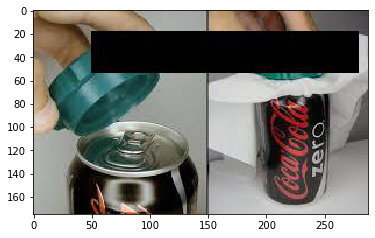

In [4]:
plt.imshow(img)

In [5]:
img.shape

(175, 288, 3)

### Step 1 - Rectangle detection

The first step, as mentioned, is to detect the black rectangle contained in each image. OpenCV's `findContours()` implements the algorithm proposed in [1], which operates on a binary image to extract its contours (and hierarchies, which we will not use in this context). 

Our images may obviously contain some black pixels other than those in the black rectangle we want to identify. As such, `findContours` will return multiple "patches" of black. We will later see how we can handle that and narrow down the list of patches to the one we are interested in.

Since the algorithm works on binary images, we first need to convert our RGB image into a binary (i.e. black and white) one. We are interested in black rectangles, so it makes sense to convert each pixel based on whether they are black or not. 

Our image `img` has been loaded by OpenCV as a numpy array with dimension (height, width, 3), where 3 is the number of channels (RGB).

With numpy arrays, we can verify whether a pixel in position (i,j) is black if `img[i,j,k] == 0` for k $\in$ {0,1,2} (i.e. all three color channels are 0). 

However, compressed images may contain some "artifacts" resulting from their compression. For example, some pixels may not be "fully" black (i.e. not (0,0,0)), but rather somewhere close to it. To account for this, we can set a threshold value below which a channel is considered to be black. This value can be tuned later on, but we can probably select a relatively good value by inspecting the results obtained on a few images.

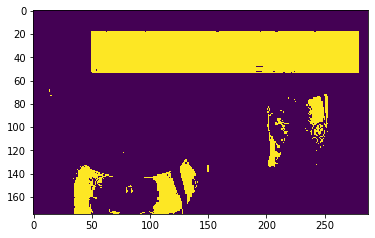

In [6]:
threshold = 20
bw = 255*((img<threshold).sum(axis=2)==3).astype(np.uint8)
plt.imshow(bw)

We can then used `findContours()` to identify the contours that can be detected in the image above. More on the parameters used can be found in the [documentation](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a).

In [7]:
_, contours, _ = cv.findContours(bw, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

`contours` will now contain a list of all contours found. We are interested in a rectangle that contains each of those contours, so we might as well use OpenCV's `boundingRect()` function, which returns the coordinates, height and width of a rectangle that contains a given set of points. 

To decide which of the many rectangles we receive as output we want to keep, we can use a very simple heuristic: since the rectangle we are looking for covers 10 to 20% of the entire image, we can assume that that rectangle will be the largest one we will find in the image. As such, we extract the largest rectangle (based on its area) as the one we are interested in.

% of image covered by largest rectangle: 16.43


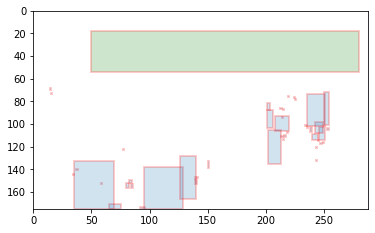

In [8]:
from matplotlib.patches import Rectangle

_, ax = plt.subplots(figsize=(6,6*img.shape[0]/img.shape[1]))
ax.set_xlim([0, img.shape[1]])
ax.set_ylim([img.shape[0], 0])

max_area = None

for i, cnt in enumerate(contours):
    a,b,c,d = cv.boundingRect(cnt)
    rect = Rectangle((a,b),c,d, fill=True, linewidth=2, edgecolor='red', alpha=.2)
    ax.add_patch(rect)
    
    if not max_area or max_area[2] * max_area[3] < c * d:
        max_area = a,b,c,d,i

ax.patches[max_area[4]].set_facecolor("green")
print(f"% of image covered by largest rectangle: {100 * max_area[2] * max_area[3] / (img.shape[0] * img.shape[1]):.2f}")

The above code plots all rectangles and identifies the "right" (largest) one, highlighted in green. 

We can also easily compute the fraction of the image that is covered by the identified rectangle (`rect_width * rect_heigh / (picture_width * picture_height)`). We know from the problem description that each picture has a black patch that covers from 10 to 20% of the image. If the identified rectangle does not cover a similar portion of the image, we can discard it as it will most likely be a false positive (i.e. it is not the rectangle we are looking for). 

### Step 2 - inpainting
Once we have identified the black rectangle we want to remove, we need to find out a way of removing it. This can be solved with an inpainting technique, a process that attempts to restore missing parts of a given image. 

Interestingly, we could use machine learning techniques to address this very problem: indeed, denoising autoencoder work in a very similar way. Given a corrupted input, the autoencoder is tasked with the reconstruction of the original one. However, training an autoencoder on this task is a time-consuming operation, which would also require access to the uncorrupted data(*).

A much simpler solution is using some of those "standard" computer vision techniques for inpainting. Lo and behold, OpenCV makes some of those functions easily available for us. More specifically, the `inpaint()` function takes as input an image, a mask (which defines the portions of the image that need to be restored) and a few additional parameters. From those, using some magic [2], OpenCV will produce a reconstructed version of the input image.

The code below prepares a boolean mask by setting to 255 the pixels that we want to reconstruct, everything else to 0. 

(*): although available on Kaggle, using the original dataset (even only for training a denoising autoencoder) seemed a bit unethical (:

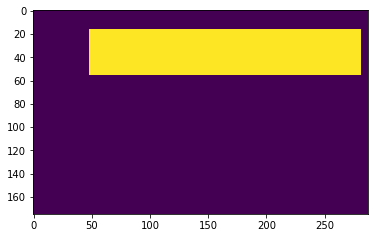

In [9]:
# we add a small offset around the rectangle we have identified.
# setting this to 0 will make it so that some of the  black pixels in the
# rectangle being will be used for the interpolation, resulting in a poor reconstruction
off = 2

a,b,c,d,_ = max_area
mask = np.zeros(img.shape[:2], np.uint8)
mask[max(b-off,0):min(b+d+off,mask.shape[0]), max(a-off,0):min(a+c+off,mask.shape[1])] = 255
plt.imshow(mask)

We now simply need to use inpaint (more info on the parameters can be found in the [official documentation](https://docs.opencv.org/4.5.2/d7/d8b/group__photo__inpaint.html#gaedd30dfa0214fec4c88138b51d678085)) and get our output image.

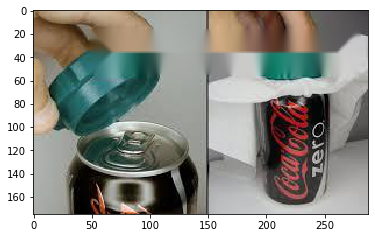

In [10]:
inpaint_radius = 3
flags = cv.INPAINT_TELEA

dst = cv.inpaint(img, mask, inpaint_radius, flags)
plt.imshow(dst)

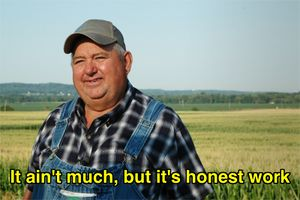

We could probably shoot for a better interpolation, sure, but this should already be less confusing for the pre-trained model (which has never seen black rectangle during its training) than the original images. Indeed, we empirically get an improvement in performance of approximately 2-3 points on the weighted F1 score (using an 80/20 train-test split). 

We can now see how the interpolation works on a bunch of random images (do keep in mind that the results will not be mind blowing, but they should be good enough to make the image go through the convolutional layers without messing up the output too badly -- as it would have happened if we introduced sharp changes in the image with those nasty rectangles).

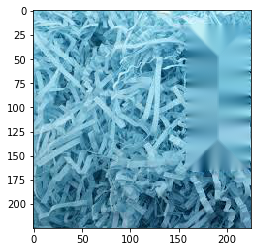

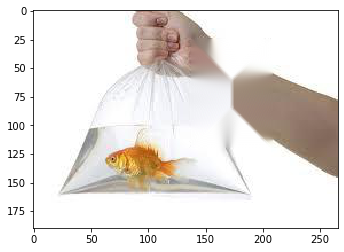

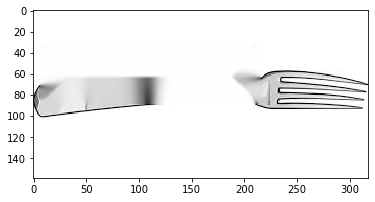

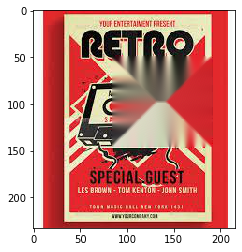

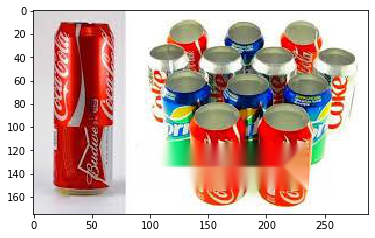

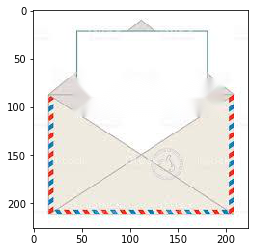

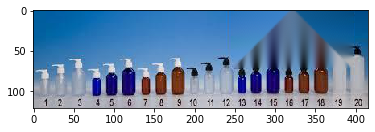

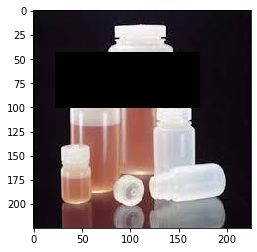

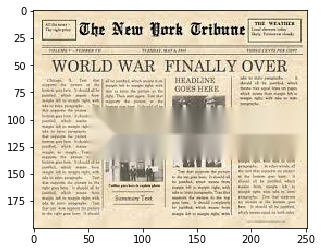

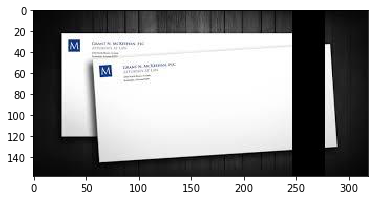

In [11]:
from preproc import RemoveRectangle
from PIL import Image

for fname in np.random.choice(glob("../dataset/TRAIN/R/*.jpg"), size=10):
    im = Image.open(fname)
    plt.figure()
    plt.imshow(RemoveRectangle()(im))

## References

[1] Suzuki, Satoshi. "Topological structural analysis of digitized binary images by border following." Computer vision, graphics, and image processing 30.1 (1985): 32-46.

[2] Telea, Alexandru. "An image inpainting technique based on the fast marching method." Journal of graphics tools 9.1 (2004): 23-34.